In [173]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import psycopg2
from contextlib import contextmanager
import logging


@contextmanager
def connect(host, port, user, password, dbname):
    try:
        connection = psycopg2.connect(host=host, port=port, user=user, password=password, dbname=dbname)
        yield connection
    except Exception as e:
        connection.rollback()
        logging.error(e)
        raise
    else:
        connection.commit()
    finally:
        connection.close()


def runSQL(sql:str):
    with connect(host='127.0.0.1', port='5432', user='postgres', password='309512', dbname='data-tutorial') as conn:
        cur = conn.cursor()
        cur.execute(sql)
        cur.close()

def runSQL_result(sql:str):
    with connect(host='127.0.0.1', port='5432', user='postgres', password='309512', dbname='data-tutorial') as conn:
        cur = conn.cursor()
        cur.execute(sql)
        result = cur.fetchall()
        cur.close()
        return result

---
# country_vaccinations

In [174]:
# data source:
# https://www.kaggle.com/gpreda/covid-world-vaccination-progress


# Country - this is the country for which the vaccination information is provided;
# Country ISO Code - ISO code for the country;
# Date - date for the data entry; for some of the dates we have only the daily vaccinations, for others, only the (cumulative) total;
# Total number of vaccinations - this is the absolute number of total immunizations in the country;
# Total number of people vaccinated - a person, depending on the immunization scheme, will receive one or more (typically 2) vaccines; at a certain moment, the number of vaccination might be larger than the number of people;
# Total number of people fully vaccinated - this is the number of people that received the entire set of immunization according to the immunization scheme (typically 2); at a certain moment in time, there might be a certain number of people that received one vaccine and another number (smaller) of people that received all vaccines in the scheme;
# Daily vaccinations (raw) - for a certain data entry, the number of vaccination for that date/country;
# Daily vaccinations - for a certain data entry, the number of vaccination for that date/country;
# Total vaccinations per hundred - ratio (in percent) between vaccination number and total population up to the date in the country;
# Total number of people vaccinated per hundred - ratio (in percent) between population immunized and total population up to the date in the country;
# Total number of people fully vaccinated per hundred - ratio (in percent) between population fully immunized and total population up to the date in the country;
# Number of vaccinations per day - number of daily vaccination for that day and country;
# Daily vaccinations per million - ratio (in ppm) between vaccination number and total population for the current date in the country;
# Vaccines used in the country - total number of vaccines used in the country (up to date);
# Source name - source of the information (national authority, international organization, local organization etc.);
# Source website - website of the source of information;

df_country_vaccinations = pd.read_csv('./country_vaccinations.csv')
print(df_country_vaccinations.dtypes, '\n')
print(df_country_vaccinations)

country                                 object
iso_code                                object
date                                    object
total_vaccinations                     float64
people_vaccinated                      float64
people_fully_vaccinated                float64
daily_vaccinations_raw                 float64
daily_vaccinations                     float64
total_vaccinations_per_hundred         float64
people_vaccinated_per_hundred          float64
people_fully_vaccinated_per_hundred    float64
daily_vaccinations_per_million         float64
vaccines                                object
source_name                             object
source_website                          object
dtype: object 

       country iso_code        date  total_vaccinations  people_vaccinated  \
0      Albania      ALB  2021-01-10                 0.0                0.0   
1      Albania      ALB  2021-01-11                 NaN                NaN   
2      Albania      ALB  2021-01-12          

In [175]:
# create = """
#     CREATE TABLE country_vaccinations (
#         country VARCHAR(255),
#         iso_code VARCHAR(255),
#         date VARCHAR(255),
#         total_vaccinations float8,
#         people_vaccinated float8,
#         people_fully_vaccinated float8,
#         daily_vaccinations_raw float8,
#         daily_vaccinations float8,
#         total_vaccinations_per_hundred float8,
#         people_vaccinated_per_hundred float8,
#         people_fully_vaccinated_per_hundred float8,
#         daily_vaccinations_per_million float8,
#         vaccines VARCHAR(255),
#         source_name VARCHAR(255),
#         source_website TEXT
#     )
#     """
# runSQL_result(create)


# # run once, copy csv to db
# with connect(host='127.0.0.1', port='5432', user='postgres', password='309512', dbname='data-tutorial') as conn:
#     cur = conn.cursor()
#     f = open('./country_vaccinations.csv', 'r')
#     copy_sql = """
#         COPY country_vaccinations FROM stdin WITH CSV HEADER
#         DELIMITER as ','
#         """
#     cur.copy_expert(sql=copy_sql, file=f)
#     f.close()
#     cur.close()

# print(runSQL('DELETE FROM country_vaccinations'))
print(runSQL_result('SELECT COUNT(*) FROM country_vaccinations'))
print(runSQL_result('SELECT * FROM country_vaccinations LIMIT 1'))

[(5140,)]
[('Albania', 'ALB', '2021-01-10', 0.0, 0.0, None, None, None, 0.0, 0.0, None, None, 'Pfizer/BioNTech', 'Ministry of Health', 'https://shendetesia.gov.al/covid19-ministria-e-shendetesise-766-te-vaksinuar-3149-testime-903-te-sheruar-851-raste-te-reja-dhe-21-humbje-jete-ne-24-oret-e-fundit/')]


Pfizer/BioNTech                                                                       25
Moderna, Oxford/AstraZeneca, Pfizer/BioNTech                                          20
Oxford/AstraZeneca                                                                    18
Sputnik V                                                                             10
Moderna, Pfizer/BioNTech                                                               7
Oxford/AstraZeneca, Pfizer/BioNTech                                                    7
Sinovac                                                                                7
Sinopharm/Beijing                                                                      6
Pfizer/BioNTech, Sinovac                                                               3
Oxford/AstraZeneca, Sinopharm/Beijing                                                  2
Oxford/AstraZeneca, Pfizer/BioNTech, Sinopharm/Beijing, Sputnik V                      2
Moderna              

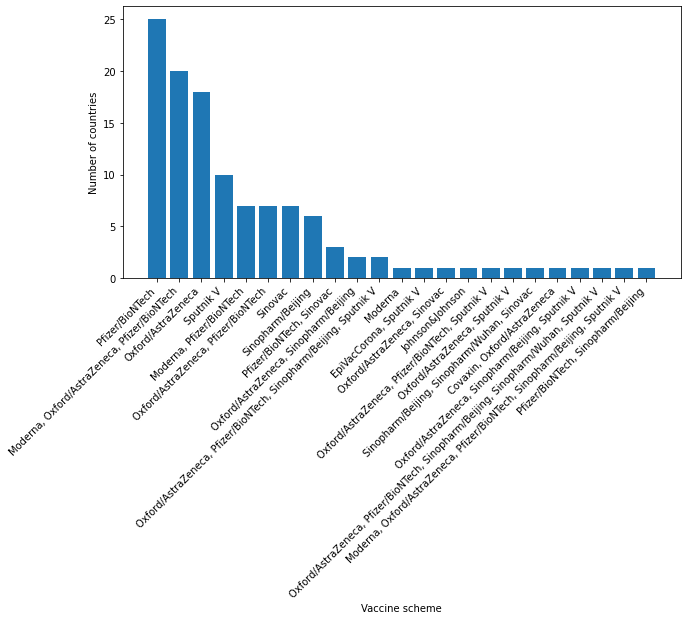

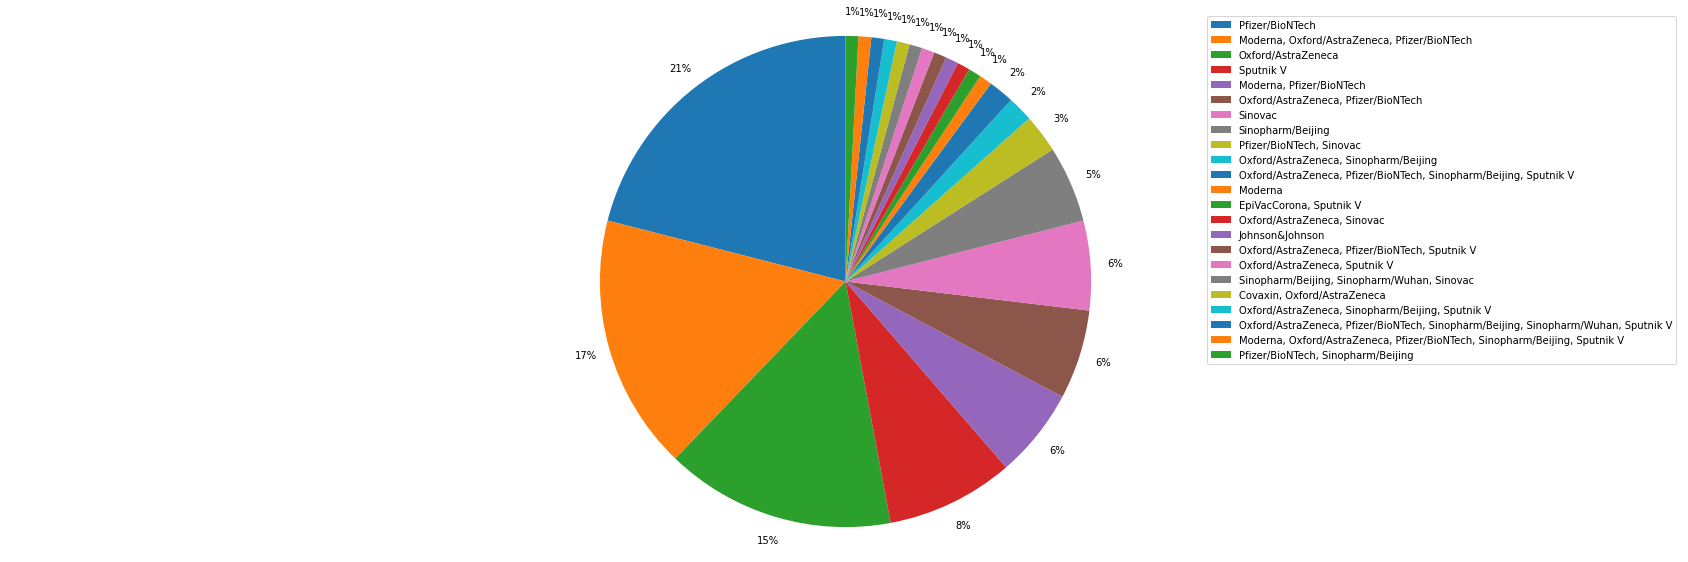

In [176]:
# group by country and only keep rows on the most recent date (since they are .max())
df_country_vaccinations_grouped = df_country_vaccinations.groupby(["country",'iso_code','vaccines']).max().reset_index()

# rank vaccine scheme counts
current_info = df_country_vaccinations_grouped['vaccines'].value_counts()
print(current_info)

fig,ax = plt.subplots(figsize=(10, 5))
plt.bar(current_info.keys().tolist(), current_info.values)
# plt.xticks(rotation=45)
ax.set_xticklabels(current_info.keys().tolist(), rotation=45, ha='right')
plt.xlabel('Vaccine scheme')
plt.ylabel('Number of countries')
plt.show()

fig1, ax1 = plt.subplots(figsize=(30, 10))
patches, texts, autotexts = ax1.pie(current_info.values, startangle=90, autopct='%1.0f%%', pctdistance=1.1)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.legend(patches, current_info.keys().tolist(), loc="best")
plt.show()

                  country  total_vaccinations
115         United States          82572848.0
21                  China          52520000.0
114        United Kingdom          21946433.0
48                  India          18005503.0
15                 Brazil           9739676.0
110                Turkey           9560038.0
53                 Israel           8555933.0
37                Germany           6813173.0
113  United Arab Emirates           6204004.0
92                 Russia           6010744.0
36                 France           5016763.0
54                  Italy           4944619.0
20                  Chile           4270024.0
75                Morocco           4233129.0
104                 Spain           4229092.0
88                 Poland           3619316.0
9              Bangladesh           3581169.0
49              Indonesia           3386351.0
70                 Mexico           2676035.0
18                 Canada           2169417.0
91                Romania         

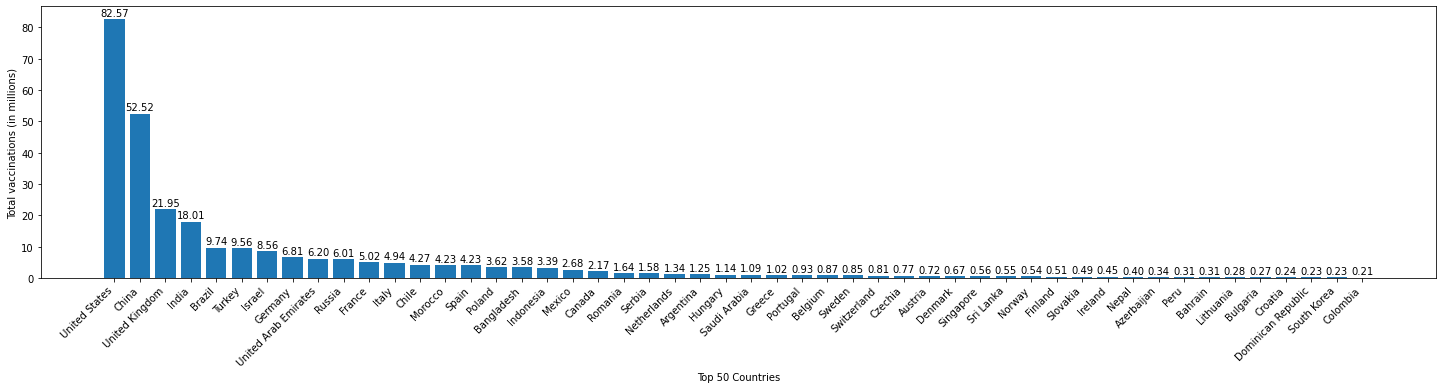

In [177]:
# rank total_vaccinations by country
current_info = df_country_vaccinations_grouped[['country','total_vaccinations']].nlargest(50,'total_vaccinations')
print(current_info)

from matplotlib.ticker import FuncFormatter

fig,ax = plt.subplots(figsize=(25, 5))
rect = plt.bar(current_info['country'], current_info['total_vaccinations'])
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: '{0:g}'.format(x/1000000))) # show y tick in millions
ax.set_xticklabels(current_info['country'], rotation=45, ha='right')
for i, v in enumerate(current_info['total_vaccinations']):
    ax.text(i, v + 1000000, "{:.2f}".format(v/1000000), ha='center')
    # ax.text(rect.get_x() + rect.get_width()/2., 1.05*rect.get_height(), '%d' % int(rect.get_height()), ha='center', va='bottom')
plt.xlabel('Top 50 Countries')
plt.ylabel('Total vaccinations (in millions)')
plt.show()


# Observations:
# when not considering population, only from absolute total_vaccinations values,
# Tier 1: US, China, UK, India
# Tier 2: Brazil, Turkey, Isreal
# Tier 3: other countries (mostly Europe countries)

---
# country_gdppc

In [178]:
# data source:
# https://data.worldbank.org/indicator/NY.GDP.PCAP.CD


# take GDPpc data from all countries from 2010-2019 as country_gdppc_simple.csv
df_country_gdppc = pd.read_csv('./country_gdppc.csv')
df_country_gdppc.drop(columns=['Indicator Name', 'Indicator Code'], inplace=True) # drop these since all the same, not used in this analysis
df_country_gdppc.drop(columns=[str(i) for i in range(1960, 2010)], inplace=True) # drop data from 1960-2009
df_country_gdppc.drop(columns=df_country_gdppc.columns[-2:], inplace=True) # drop empty 2020 column and empty last unnamed column
print(df_country_gdppc.dtypes, '\n')
print(df_country_gdppc)
# df_country_gdppc.to_csv('./country_gdppc_simple.csv', index=False)

Country Name     object
Country Code     object
2010            float64
2011            float64
2012            float64
2013            float64
2014            float64
2015            float64
2016            float64
2017            float64
2018            float64
2019            float64
dtype: object 

     Country Name Country Code          2010          2011          2012  \
0           Aruba          ABW  23512.602596  24985.993281  24713.698045   
1     Afghanistan          AFG    543.303042    591.162759    641.871479   
2          Angola          AGO   3587.883798   4615.468028   5100.095808   
3         Albania          ALB   4094.350334   4437.142885   4247.629984   
4         Andorra          AND  40852.666777  43335.328862  38686.461264   
..            ...          ...           ...           ...           ...   
259        Kosovo          XKX   3286.557443   3741.875052   3596.804655   
260   Yemen, Rep.          YEM   1334.784845   1374.621285   1446.536354   
261  South A

In [179]:
# create = """
#     CREATE TABLE country_gdppc_simple (
#         country VARCHAR(255),
#         iso_code VARCHAR(255),
#         _2010 float8,
#         _2011 float8,
#         _2012 float8,
#         _2013 float8,
#         _2014 float8,
#         _2015 float8,
#         _2016 float8,
#         _2017 float8,
#         _2018 float8,
#         _2019 float8
#     )
#     """
# runSQL_result(create)


# # run once, copy csv to db
# with connect(host='127.0.0.1', port='5432', user='postgres', password='309512', dbname='data-tutorial') as conn:
#     cur = conn.cursor()
#     f = open('./country_gdppc_simple.csv', 'r')
#     copy_sql = """
#         COPY country_gdppc_simple FROM stdin WITH CSV HEADER
#         DELIMITER as ','
#         """
#     cur.copy_expert(sql=copy_sql, file=f)
#     f.close()
#     cur.close()

# print(runSQL('DELETE FROM country_gdppc_simple'))
print(runSQL_result('SELECT COUNT(*) FROM country_gdppc_simple'))
print(runSQL_result('SELECT * FROM country_gdppc_simple LIMIT 1'))

[(264,)]
[('Aruba', 'ABW', 23512.602595639702, 24985.9932813737, 24713.6980451285, 26189.4355088129, 26647.938100985, 27980.880695275097, 28281.35048163, 29007.6930034887, None, None)]


In [180]:
# find correlation between total_vaccinations and 2019 DGPpc
left = df_country_vaccinations_grouped[['iso_code', 'total_vaccinations', 'total_vaccinations_per_hundred']]
right = df_country_gdppc[['Country Code', '2019']]
right.columns = ['iso_code', 'GDPpc_2019'] # rename columns
df_correlation_data = pd.merge(left, right, on='iso_code') # INNER JOIN ON iso_code
df_correlation_data = df_correlation_data.dropna()
print(df_correlation_data)
# df_correlation_data.to_csv('./df_correlation_data.csv', index=False)

df_correlation_data.drop(columns=['iso_code'], inplace=True) # drop iso_code since not used in correlation
correlation_matrix = df_correlation_data.corr()
correlation_matrix.style.background_gradient(cmap='coolwarm')

    iso_code  total_vaccinations  total_vaccinations_per_hundred    GDPpc_2019
0        ALB             15793.0                            0.55   5353.244856
1        DZA             75000.0                            0.17   3973.964072
2        AND              2526.0                            3.27  40886.391165
3        ARG           1252461.0                            2.77   9912.281809
4        AUS             61008.0                            0.24  55060.326101
..       ...                 ...                             ...           ...
106      ARE           6204004.0                           62.73  43103.323058
107      GBR          21946433.0                           32.33  42330.117537
108      USA          82572848.0                           24.69  65297.517508
109      URY             54154.0                            1.56  16190.126957
111      ZWE             30658.0                            0.21   1463.985910

[102 rows x 4 columns]


,total_vaccinations,total_vaccinations_per_hundred,GDPpc_2019
total_vaccinations,1.000000,0.176593,0.103597
total_vaccinations_per_hundred,0.176593,1.000000,0.266324
GDPpc_2019,0.103597,0.266324,1.000000


---
# human-development-index

In [247]:
# data source
# df_hdi_2019: http://hdr.undp.org/en/data
# df_hdi_2017: https://ourworldindata.org/human-development-index

# df_hdi_2017 has iso_code, but df_hdi_2019 does not
# cannot join
# TODO: use data in 2019 with iso_code

df_hdi_2017 = pd.read_csv('./human-development-index.csv')
print(df_hdi_2017.dtypes, '\n')
# print(df_hdi_2017)

df_hdi_2019 = pd.read_csv('./Human Development Index (HDI).csv')
print(df_hdi_2019.dtypes, '\n')
# print(df_hdi_2019)


df_hdi_2017 = df_hdi_2017[df_hdi_2017['Year'] == 2017]
# len = 190
print(df_hdi_2017, '\n')
# len = 189
print(df_hdi_2019['2019'].iloc[:189], '\n')
# len not equal, cannot proceed


df_hdi_2017.to_csv('./df_hdi_2017.csv', index=False)
# manually add hdi_2019
# change file name to df_hdi_2019_with_iso_code.csv
df_hdi_2019_with_iso_code = pd.read_csv('./df_hdi_2019_with_iso_code.csv')
print(df_hdi_2019_with_iso_code, '\n')

Entity                             object
Code                               object
Year                                int64
Human Development Index (UNDP)    float64
dtype: object 

HDI Rank        object
Country         object
1990            object
Unnamed: 3     float64
1991            object
                ...   
Unnamed: 57    float64
2018            object
Unnamed: 59    float64
2019            object
Unnamed: 61    float64
Length: 62, dtype: object 

           Entity Code  Year  Human Development Index (UNDP)
17    Afghanistan  AFG  2017                           0.498
47        Albania  ALB  2017                           0.785
75        Algeria  DZA  2017                           0.754
93        Andorra  AND  2017                           0.858
112        Angola  AGO  2017                           0.581
...           ...  ...   ...                             ...
4882    Venezuela  VEN  2017                           0.761
4912      Vietnam  VNM  2017                   

In [254]:
# find correlation
left = df_country_vaccinations_grouped[['iso_code', 'total_vaccinations', 'total_vaccinations_per_hundred']]
right = df_hdi_2019_with_iso_code[['Code', 'hdi_2019']]
right.columns = ['iso_code', 'hdi_2019'] # rename columns
df_correlation_data = pd.merge(left, right, on='iso_code') # INNER JOIN ON iso_code
df_correlation_data = df_correlation_data.dropna()
print(df_correlation_data)
# df_correlation_data.to_csv('./df_correlation_data.csv', index=False)

df_correlation_data.drop(columns=['iso_code'], inplace=True) # drop iso_code since not used in correlation
correlation_matrix = df_correlation_data.corr()
correlation_matrix.style.background_gradient(cmap='coolwarm')

    iso_code  total_vaccinations  total_vaccinations_per_hundred  hdi_2019
0        ALB             15793.0                            0.55     0.795
1        DZA             75000.0                            0.17     0.748
2        AND              2526.0                            3.27     0.868
3        ARG           1252461.0                            2.77     0.845
4        AUS             61008.0                            0.24     0.944
..       ...                 ...                             ...       ...
97       GBR          21946433.0                           32.33     0.932
98       USA          82572848.0                           24.69     0.926
99       URY             54154.0                            1.56     0.817
100      VEN               157.0                            0.00     0.711
101      ZWE             30658.0                            0.21     0.571

[102 rows x 4 columns]


,total_vaccinations,total_vaccinations_per_hundred,hdi_2019
total_vaccinations,1.000000,0.187761,0.086552
total_vaccinations_per_hundred,0.187761,1.000000,0.279015
hdi_2019,0.086552,0.279015,1.000000


---
# corruption-perception-index

In [255]:
# data source
# https://ourworldindata.org/human-development-index


df_corruption_perception_index = pd.read_csv('./human-development-index-vs-corruption-perception-index.csv')
print(df_corruption_perception_index.dtypes, '\n')


df_corruption_perception_index = df_corruption_perception_index[df_corruption_perception_index['Year'] == 2018]
print(df_corruption_perception_index, '\n')

Entity                                                              object
Code                                                                object
Year                                                                 int64
Total population (Gapminder, HYDE & UN)                            float64
Continent                                                           object
Human Development Index (UNDP)                                     float64
Corruption Perception Index - Transparency International (2018)    float64
dtype: object 

               Entity      Code  Year  \
219       Afghanistan       AFG  2018   
341            Africa       NaN  2018   
562           Albania       ALB  2018   
782           Algeria       DZA  2018   
852    American Samoa       ASM  2018   
...               ...       ...   ...   
46149  Western Sahara       ESH  2018   
46300           World  OWID_WRL  2018   
46521           Yemen       YEM  2018   
46744          Zambia       ZMB  2018   
46965   

In [258]:
# find correlation
left = df_country_vaccinations_grouped[['iso_code', 'total_vaccinations', 'total_vaccinations_per_hundred']]
right = df_corruption_perception_index[['Code', 'Corruption Perception Index - Transparency International (2018)']]
right.columns = ['iso_code', 'corruption_2018'] # rename columns
df_correlation_data = pd.merge(left, right, on='iso_code') # INNER JOIN ON iso_code
df_correlation_data = df_correlation_data.dropna()
print(df_correlation_data)
# df_correlation_data.to_csv('./df_correlation_data.csv', index=False)

df_correlation_data.drop(columns=['iso_code'], inplace=True) # drop iso_code since not used in correlation
correlation_matrix = df_correlation_data.corr()
correlation_matrix.style.background_gradient(cmap='coolwarm')

    iso_code  total_vaccinations  total_vaccinations_per_hundred  \
0        ALB             15793.0                            0.55   
1        DZA             75000.0                            0.17   
4        ARG           1252461.0                            2.77   
5        AUS             61008.0                            0.24   
6        AUT            722964.0                            8.03   
..       ...                 ...                             ...   
111      GBR          21946433.0                           32.33   
112      USA          82572848.0                           24.69   
113      URY             54154.0                            1.56   
114      VEN               157.0                            0.00   
115      ZWE             30658.0                            0.21   

     corruption_2018  
0               36.0  
1               35.0  
4               40.0  
5               77.0  
6               76.0  
..               ...  
111             80.0  

,total_vaccinations,total_vaccinations_per_hundred,corruption_2018
total_vaccinations,1.000000,0.186984,0.094335
total_vaccinations_per_hundred,0.186984,1.000000,0.298450
corruption_2018,0.094335,0.298450,1.000000
